In [162]:
import pandas as pd
import numpy as np
import networkx as nx
#import geopandas
#from shapely.geometry import Point
import matplotlib.pyplot as plt
from sodapy import Socrata

In [163]:
def getData(limit):
    client = Socrata("data.cityofnewyork.us", None)
    results = client.get("2yzn-sicd", limit = limit)
    results_df = pd.DataFrame.from_records(results)
    return results_df

In [164]:
taxi = getData(50)

In [165]:
taxi["dropoff_latitude"] = taxi["dropoff_latitude"].astype('float64')
taxi["dropoff_longitude"] = taxi["dropoff_longitude"].astype('float64')
taxi["pickup_latitude"] = taxi["pickup_latitude"].astype('float64')
taxi["pickup_longitude"] = taxi["pickup_longitude"].astype('float64')
print(len(taxi))
taxi_filtered = taxi
for i in range (len(taxi)) :
    if float(taxi_filtered.loc[i,'dropoff_latitude']) == 0 or float(taxi_filtered.loc[i,'dropoff_longitude']) == 0 or float(taxi_filtered.loc[i,'pickup_latitude']) == 0 or float(taxi_filtered.loc[i,'pickup_longitude']) == 0:
        taxi_filtered = taxi_filtered.drop(i)
coordinates = taxi_filtered[['pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude']]
print(len(coordinates))

50
49


In [166]:
lol=coordinates
pickup=lol.drop(["dropoff_longitude","dropoff_latitude"],axis=1)
dropoff=lol.drop(["pickup_longitude","pickup_latitude"],axis=1)

In [167]:
tuples=pickup.itertuples(index=False)
pickup_tuples=np.array(list(tuples))
tuples=dropoff.itertuples(index=False)
dropoff_tuples=np.array(list(tuples))

In [168]:
pickup_tuples=pickup_tuples.astype('float64')
dropoff_tuples=dropoff_tuples.astype('float64')

In [169]:
print(len(np.unique(pickup_tuples,axis=0)))
print(len(pickup_tuples))
print(len(np.unique(pickup_tuples,axis=0)))
print(len(dropoff_tuples))

49
49
49
49


In [170]:
pickup_tuples=pickup_tuples.round(2)
dropoff_tuples=dropoff_tuples.round(2)

In [171]:
print(len(np.unique(pickup_tuples,axis=0)))
print(len(pickup_tuples))
print(len(np.unique(pickup_tuples,axis=0)))
print(len(dropoff_tuples))

25
49
25
49


In [172]:
pickup_tuples_invert=[]
dropoff_tuples_invert=[]

for i in range(len(pickup_tuples)):
    #print(pickup_tuples[i])
    pickup_tuples_invert.append([pickup_tuples[i,1],pickup_tuples[i,0]])
pickup_tuples=np.array(pickup_tuples_invert)

for i in range(len(dropoff_tuples)):
    #print(dropoff_tuples[i])
    dropoff_tuples_invert.append([dropoff_tuples[i,1],dropoff_tuples[i,0]])
dropoff_tuples=np.array(dropoff_tuples_invert)

In [173]:
pickup_list=[]
for i in range(len(pickup_tuples)):
    a=(pickup_tuples[i,0],pickup_tuples[i,1])
    pickup_list.append(a)
dropoff_list=[]
for i in range(len(dropoff_tuples)):
    a=(dropoff_tuples[i,0],dropoff_tuples[i,1])
    dropoff_list.append(a)
#print(tuple_list)

In [174]:
edges=[]
for i in range(len(pickup_list)):
    edges.append((pickup_list[i],dropoff_list[i]))

In [175]:
edges,index=np.unique(np.array(edges),axis=0,return_counts=True)

In [176]:
a=max(index)

In [177]:
index[index<=(a/2)]=0
index[index>(a/2)]=1
#index=index[index>=(a/2)]

In [178]:
colors=[]
for i in range(len(index)):
    if index[i]==1:
        colors.append("r")
    else:
        colors.append("b")

In [179]:
edge_tuples=[]
for i in range(len(edges)):
    edge_tuples.append(((edges[i,0,0],edges[i,0,1]),(edges[i,1,0],edges[i,1,1])))

In [180]:
#g=nx.Graph()
g=nx.DiGraph()

In [181]:
node_list=[]
for i in range(len(pickup_list)):
    node_list.append(pickup_list[i])
for i in range(len(dropoff_list)):
    node_list.append(dropoff_list[i])
print(len(node_list))
node_list=list(set(node_list))
print(len(node_list))
g.add_nodes_from(node_list)

98
39


In [182]:
g.add_edges_from(edge_tuples)

In [183]:
position = {}
for i in range(len(node_list)):
    position.update({node_list[i]:node_list[i]})

In [184]:
nx.average_clustering(g)

0.022364672364672364

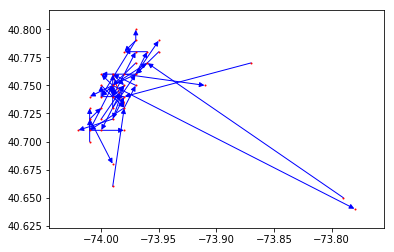

In [185]:
nx.draw_networkx(g, node_size = 1,pos=position,with_labels=False,edge_color=colors)

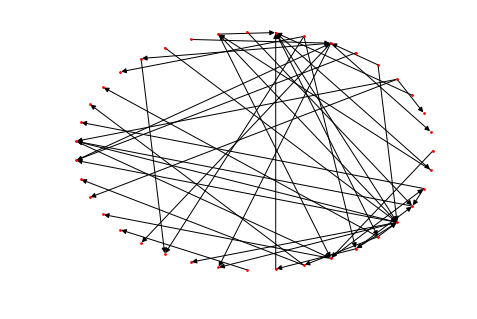

In [186]:
nx.draw_circular(g,node_size=3)

In [187]:
from networkx.algorithms import community

IndexError: list index out of range

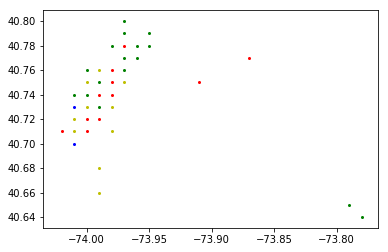

In [188]:
communities_generator = community.girvan_newman(g)
top_level_communities = next(communities_generator)
next_level_communities = next(communities_generator)
com = sorted(map(sorted, next_level_communities))
#nx.draw_networkx_nodes(G,pos,nodelist=com[2],node_color='b',node_size=1,alpha=0.8)
#position
#nx.draw_networkx(g, node_size = 1,pos=position,with_labels=False)
nx.draw_networkx_nodes(g,position,nodelist=com[0],node_color='r',node_size=4,with_labels=False)
nx.draw_networkx_nodes(g,position,nodelist=com[1],node_color='b',node_size=4,with_labels=False)
nx.draw_networkx_nodes(g,position,nodelist=com[2],node_color='y',node_size=4,with_labels=False)
nx.draw_networkx_nodes(g,position,nodelist=com[3],node_color='g',node_size=4,with_labels=False)
nx.draw_networkx_nodes(g,position,nodelist=com[4],node_color='w',node_size=4,with_labels=False)
nx.draw_networkx_nodes(g,position,nodelist=com[5],node_color='c',node_size=4,with_labels=False)

#nx.draw_networkx_edges(g,node_size = 1,pos=position)

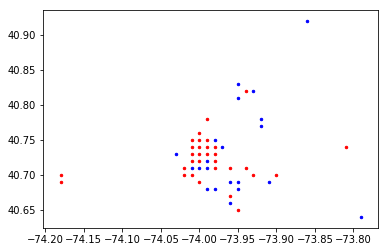

In [129]:
c = list(community.greedy_modularity_communities(g))
com = [tuple(x) for x in c[1]]
nx.draw_networkx_nodes(g,position,nodelist=com,node_color='r',node_size=6,with_labels=False)

com = [tuple(x) for x in c[2]]
nx.draw_networkx_nodes(g,position,nodelist=com,node_color='b',node_size=6,with_labels=False)

In [251]:
import networkx as nx

from bokeh.io import show, output_file
from bokeh.plotting import figure
from bokeh.models.graphs import from_networkx

G=nx.karate_club_graph()

plot = figure(title="Networkx Integration Demonstration",
              tools="", toolbar_location=None)

graph = from_networkx(g, nx.circular_layout)
plot.renderers.append(graph)

output_file("networkx_graph.html")
show(plot)

ValueError: expected an element of Dict(Either(String, Int), Seq(Any)), got {(-73.95, 40.7): array([1.00000000e+00, 2.61931054e-09]), (-73.8, 40.67): array([0.99912286, 0.04187566]), (-73.94, 40.72): array([0.99649286, 0.08367785]), (-73.95, 40.76): array([0.99211472, 0.12533324]), (-74.18, 40.69): array([0.98599601, 0.16676875]), (-73.99, 40.75): array([0.97814763, 0.2079117 ]), (-73.98, 40.75): array([0.96858317, 0.24868991]), (-73.96, 40.66): array([0.9573195 , 0.28903178]), (-73.95, 40.71): array([0.94437635, 0.32886663]), (-73.96, 40.71): array([0.92977649, 0.36812455]), (-73.94, 40.81): array([0.91354543, 0.40673664]), (-73.97, 40.78): array([0.89571178, 0.44463518]), (-73.99, 40.7): array([0.87630665, 0.48175371]), (-73.97, 40.74): array([0.85536426, 0.51802701]), (-73.89, 40.73): array([0.83292127, 0.55339152]), (-73.92, 40.78): array([0.809017  , 0.58778525]), (-73.96, 40.69): array([0.78369343, 0.62114775]), (-73.95, 40.69): array([0.75699508, 0.65342057]), (-74.0, 40.57): array([0.72896862, 0.68454713]), (-74.03, 40.73): array([0.69966334, 0.71447265]), (-73.97, 40.79): array([0.66913056, 0.74314487]), (-73.99, 40.71): array([0.63742399, 0.77051324]), (-73.93, 40.82): array([0.60459912, 0.79652989]), (-73.98, 40.71): array([0.57071358, 0.82114923]), (-73.94, 40.82): array([0.53582674, 0.84432793]), (-74.18, 40.7): array([0.49999997, 0.86602545]), (-74.0, 40.64): array([0.46329603, 0.88620359]), (-73.94, 40.84): array([0.42577931, 0.90482706]), (-74.0, 40.76): array([0.38751564, 0.92186314]), (-74.01, 40.74): array([0.34857199, 0.93728203]), (-73.9, 40.75): array([0.30901697, 0.95105654]), (-74.0, 40.74): array([0.2689198 , 0.96316254]), (-74.01, 40.71): array([0.22835088, 0.97357893]), (-74.0, 40.75): array([0.18738134, 0.98228723]), (-74.0, 40.73): array([0.14608309, 0.9892723 ]), (-74.0, 40.72): array([0.10452842, 0.99452192]), (-73.91, 40.75): array([0.0627905 , 0.99802673]), (-74.02, 40.72): array([0.02094243, 0.99978066]), (-73.86, 40.92): array([-0.02094239,  0.99978066]), (-73.97, 40.69): array([-0.06279047,  0.99802673]), (-73.88, 40.68): array([-0.10452851,  0.99452192]), (-73.86, 40.73): array([-0.14608306,  0.98927236]), (-73.98, 40.77): array([-0.18738131,  0.98228723]), (-73.93, 40.74): array([-0.22835085,  0.97357893]), (-73.98, 40.69): array([-0.26891976,  0.9631626 ]), (-73.97, 40.8): array([-0.30901703,  0.95105648]), (-73.94, 40.83): array([-0.34857207,  0.93728197]), (-73.96, 40.65): array([-0.3875156 ,  0.92186314]), (-73.9, 40.76): array([-0.42577937,  0.904827  ]), (-73.91, 40.76): array([-0.46329599,  0.88620359]), (-73.95, 40.65): array([-0.50000006,  0.86602539]), (-73.91, 40.69): array([-0.53582674,  0.84432799]), (-73.94, 40.75): array([-0.57071358,  0.82114923]), (-73.96, 40.8): array([-0.60459918,  0.79652983]), (-73.84, 40.72): array([-0.63742399,  0.77051324]), (-73.95, 40.8): array([-0.66913068,  0.74314481]), (-73.87, 40.77): array([-0.69966328,  0.71447271]), (-73.9, 40.74): array([-0.72896862,  0.68454707]), (-73.8, 40.76): array([-0.75699514,  0.65342051]), (-73.88, 40.77): array([-0.78369343,  0.62114781]), (-73.99, 40.78): array([-0.80901706,  0.58778519]), (-73.78, 40.64): array([-0.8329212 ,  0.55339164]), (-73.93, 40.67): array([-0.85536426,  0.51802701]), (-73.83, 40.75): array([-0.87630665,  0.48175377]), (-73.93, 40.76): array([-0.89571178,  0.44463521]), (-73.97, 40.75): array([-0.91354549,  0.40673658]), (-73.95, 40.83): array([-0.92977649,  0.36812461]), (-73.98, 40.76): array([-0.94437641,  0.32886663]), (-73.95, 40.78): array([-0.95731944,  0.2890319 ]), (-73.86, 40.77): array([-0.96858316,  0.24868991]), (-73.99, 40.72): array([-0.97814762,  0.20791161]), (-73.99, 40.69): array([-0.985996  ,  0.16676881]), (-73.96, 40.78): array([-0.99211472,  0.12533321]), (-73.98, 40.78): array([-0.99649286,  0.08367795]), (-73.99, 40.76): array([-0.99912285,  0.04187567]), (-73.95, 40.77): array([-9.99999997e-01, -8.48034659e-08]), (-73.78, 40.65): array([-0.99912285, -0.0418756 ]), (-73.9, 40.77): array([-0.99649286, -0.08367789]), (-73.97, 40.71): array([-0.99211472, -0.12533313]), (-73.94, 40.68): array([-0.985996  , -0.16676874]), (-73.92, 40.69): array([-0.97814756, -0.20791179]), (-73.99, 40.74): array([-0.96858316, -0.24868984]), (-73.97, 40.76): array([-0.95731949, -0.28903183]), (-73.98, 40.74): array([-0.94437641, -0.32886657]), (-73.94, 40.85): array([-0.92977649, -0.36812454]), (-73.89, 40.77): array([-0.91354543, -0.40673673]), (-73.79, 40.64): array([-0.89571178, -0.44463515]), (-73.95, 40.79): array([-0.87630665, -0.4817537 ]), (-73.96, 40.79): array([-0.85536432, -0.51802694]), (-73.81, 40.65): array([-0.8329212 , -0.55339157]), (-73.93, 40.77): array([-0.80901694, -0.58778536]), (-74.02, 40.7): array([-0.78369349, -0.62114775]), (-73.89, 40.75): array([-0.75699502, -0.65342062]), (-73.96, 40.81): array([-0.72896868, -0.68454706]), (-73.98, 40.72): array([-0.69966334, -0.71447271]), (-73.9, 40.7): array([-0.6691305 , -0.74314487]), (-73.95, 40.81): array([-0.63742381, -0.77051335]), (-73.79, 40.65): array([-0.60459906, -0.79652994]), (-73.99, 40.77): array([-0.57071364, -0.82114917]), (-73.92, 40.74): array([-0.53582698, -0.8443278 ]), (-73.99, 40.73): array([-0.49999991, -0.86602544]), (-73.98, 40.79): array([-0.46329605, -0.88620358]), (-73.96, 40.76): array([-0.42577943, -0.90482699]), (-73.91, 40.77): array([-0.38751542, -0.92186319]), (-73.95, 40.82): array([-0.34857201, -0.93728202]), (-73.97, 40.77): array([-0.30901709, -0.95105648]), (-73.96, 40.82): array([-0.26891961, -0.9631626 ]), (-73.96, 40.74): array([-0.22835079, -0.97357893]), (-73.92, 40.77): array([-0.18738137, -0.98228722]), (-73.94, 40.78): array([-0.14608323, -0.98927229]), (-73.97, 40.81): array([-0.10452834, -0.99452191]), (-73.76, 40.7): array([-0.06279053, -0.99802672]), (-73.98, 40.67): array([-0.02094257, -0.99978065]), (-74.0, 40.68): array([ 0.0209426 , -0.99978065]), (-73.98, 40.73): array([ 0.06279056, -0.99802672]), (-73.94, 40.62): array([ 0.10452836, -0.99452191]), (-73.81, 40.74): array([ 0.14608325, -0.98927229]), (-73.93, 40.7): array([ 0.1873814 , -0.98228722]), (-73.95, 40.72): array([ 0.22835082, -0.97357893]), (-73.96, 40.72): array([ 0.26891965, -0.9631626 ]), (-73.94, 40.7): array([ 0.30901712, -0.95105648]), (-73.96, 40.77): array([ 0.34857205, -0.93728196]), (-73.94, 40.79): array([ 0.38751546, -0.92186319]), (-73.98, 40.68): array([ 0.42577946, -0.90482699]), (-73.99, 40.68): array([ 0.46329609, -0.88620352]), (-73.93, 40.79): array([ 0.49999991, -0.86602544]), (-73.96, 40.67): array([ 0.53582662, -0.84432804]), (-73.92, 40.83): array([ 0.57071364, -0.82114917]), (-73.96, 40.68): array([ 0.60459906, -0.79652994]), (-73.91, 40.78): array([ 0.63742387, -0.77051335]), (-73.94, 40.71): array([ 0.66913074, -0.74314475]), (-73.97, 40.68): array([ 0.69966334, -0.71447265]), (-73.92, 40.76): array([ 0.72896856, -0.68454718]), (-73.9, 40.62): array([ 0.7569952 , -0.65342044]), (-73.96, 40.73): array([ 0.78369349, -0.62114775]), (-73.96, 40.75): array([ 0.80901694, -0.5877853 ]), (-73.94, 40.8): array([ 0.83292109, -0.55339175]), (-73.95, 40.75): array([ 0.85536432, -0.51802688]), (-73.93, 40.8): array([ 0.87630665, -0.4817537 ]), (-73.9, 40.64): array([ 0.89571166, -0.44463533]), (-74.03, 40.76): array([ 0.91354555, -0.40673649]), (-74.01, 40.72): array([ 0.92977649, -0.36812454]), (-74.01, 40.73): array([ 0.94437635, -0.32886675]), (-74.0, 40.69): array([ 0.95731956, -0.28903159]), (-74.02, 40.71): array([ 0.96858317, -0.24868981]), (-74.01, 40.75): array([ 0.97814757, -0.20791176]), (-73.95, 40.68): array([ 0.98599601, -0.16676895]), (-74.0, 40.71): array([ 0.99211472, -0.12533311]), (-74.0, 40.77): array([ 0.99649286, -0.08367786]), (-74.01, 40.7): array([ 0.9991228 , -0.04187581])}